In [202]:
import pandas as pd
import numpy as np
import html.parser as htmlparser
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
import sklearn.metrics as skm
from matplotlib import pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB

In [203]:
#1b
df = pd.read_csv("../Data/Youtube04-Eminem.csv")

s = df.CLASS[df.CLASS == 1].index.tolist()
h = df.CLASS[df.CLASS == 0].index.tolist()
traini = s[:int(len(s)*0.8)] + h[:int(len(h)*0.8)]
testi = s[int(len(s)*0.8):] + h[int(len(h)*0.8):]

train_set = df.iloc[traini]
test_set = df.iloc[testi]

In [204]:
#1c TDIDF using the entire dataset as the corpus
## CREATE VECTORIZER
v = TfidfVectorizer()
X = v.fit_transform(df.CONTENT)
X_df = pd.DataFrame(X.toarray())

X_train = X_df.iloc[traini]
X_test = X_df.iloc[testi]
y_train = train_set.CLASS
y_test = test_set.CLASS

In [205]:
#d i. 5-fold cross-validation
l = 10**np.linspace(-5, 5, 11)
kf = KFold(n_splits=5)
mean_agg = []
for i in range(len(l)):
    lr = LogisticRegression(penalty = 'l2', C = 1/l[i], solver='lbfgs')
    error_ptg = []
    for train_index, test_index in kf.split(X_train):
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_tr, X_va = X_train.iloc[train_index], X_train.iloc[test_index]
        y_tr, y_va = y_train.iloc[train_index], y_train.iloc[test_index]
        lr.fit(X_tr, y_tr)
        prediction = lr.predict(X_va)

        # Calculate percentage difference
        diff = pd.DataFrame({'different': prediction != y_va})
        percentage = diff['different'].value_counts(normalize=True) * 100
        error_ptg.append(percentage[True])
    mean_agg.append(np.mean(error_ptg))
penalty = l[np.argmin(mean_agg)]
print("Penalty term: " + str(penalty))

Penalty term: 1e-05


Confusion matrix: 
[[162   0]
 [  0 196]]
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Area Under Curve: 1.0


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


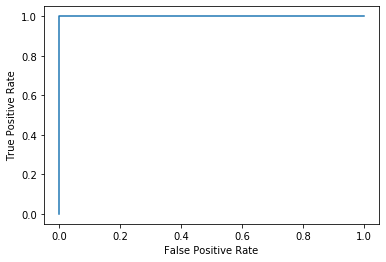

In [206]:
#1d. ii TRAINING SET
lg = LogisticRegression(penalty = 'l2', C = 1/penalty)
lg.fit(X_train, y_train)
prediction = lg.predict(X_train)
predict_prob = lg.predict_proba(X_train)

conf_matrix = skm.confusion_matrix(y_train, prediction)
print("Confusion matrix: \n" + str(conf_matrix))
#ROC?

precision = skm.precision_score(y_train, prediction)
print("Precision: " + str(precision))

recall = skm.recall_score(y_train, prediction)
print("Recall: " + str(recall))
#print(precision)
#print(recall)
f1 = skm.f1_score(y_train, prediction)
print("F1 Score: " + str(f1))

#ROC
# Subset the probabilities of the positive class
pos_prob = predict_prob[:, 1]
fpr, tpr, _ = skm.roc_curve(y_train, pos_prob)

plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# ROC AUC
auc = skm.roc_auc_score(y_train, pos_prob)
print("Area Under Curve: " + str(auc))


[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1
 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Confusion matrix: 
[[40  1]
 [ 3 46]]
Precision: 0.9787234042553191
Recall: 0.9387755102040817
F1 Score: 0.9583333333333333
Area Under Curve: 0.9955201592832255
Beta 0.1: 0.9783112234154558
Beta 0.5: 0.970464135021097
Beta 0.9: 0.9604337293805514
Beta 1: 0.9583333333333333
Beta 5: 0.9402515723270441
Beta 10: 0.9391550434606833


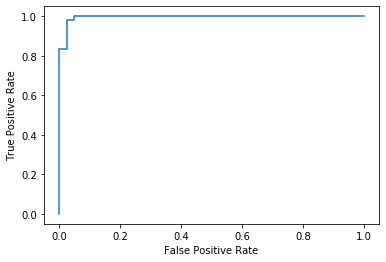

In [207]:
#1d. iii. TEST SET

prediction = lg.predict(X_test)
predict_prob = lg.predict_proba(X_test)
print(prediction)

conf_matrix = skm.confusion_matrix(y_test, prediction)
print("Confusion matrix: \n" + str(conf_matrix))
#ROC?

precision = skm.precision_score(y_test, prediction)
print("Precision: " + str(precision))

recall = skm.recall_score(y_test, prediction)
print("Recall: " + str(recall))
#print(precision)
#print(recall)
f1 = skm.f1_score(y_test, prediction)
print("F1 Score: " + str(f1))

#ROC
# Subset the probabilities of the positive class
pos_prob = predict_prob[:, 1]
fpr, tpr, _ = skm.roc_curve(y_test, pos_prob)

plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# ROC AUC
auc = skm.roc_auc_score(y_test, pos_prob)
print("Area Under Curve: " + str(auc))

# F_Beta score
beta = [0.1, 0.5, 0.9, 1, 5, 10]
for b in beta:
    f_b = skm.fbeta_score(y_test, prediction, b)
    print("Beta " + str(b) + ": " + str(f_b))

In [208]:
#1e) i. 5-fold cross validation with L1 penalization
l = 10**np.linspace(-5, 5, 11)

kf = KFold(n_splits=5, random_state=0)
mean_agg = []
for i in range(len(l)-4):
    lr = LogisticRegression(penalty = 'l1', C = 1/l[i], solver='liblinear')
    error_ptg = []
    for train_index, test_index in kf.split(X_train):
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_tr, X_va = X_train.iloc[train_index], X_train.iloc[test_index]
        y_tr, y_va = y_train.iloc[train_index], y_train.iloc[test_index]
        lr.fit(X_tr, y_tr)
        prediction = lr.predict(X_va)
        #delete this later
        score = lr.score(X_test, y_test)
        avg_score += score
        
        # Calculate percentage difference
        diff = pd.DataFrame({'different': prediction != y_va})
        percentage = 100*diff['different'].value_counts(normalize=True)
        error_ptg.append(percentage[True])
    mean_agg.append(np.mean(error_ptg))
penalty = l[np.argmin(mean_agg)]
print("Penalty term: " + str(penalty))
## PENALTY TERM: 0.1

Penalty term: 0.1


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Confusion matrix: 
[[162   0]
 [  0 196]]
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Area Under Curve: 1.0


/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


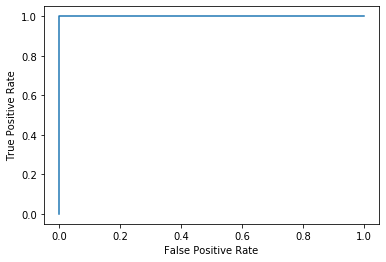

In [209]:
#1d. ii TRAINING SET
lg = LogisticRegression(penalty = 'l1', C = 1/penalty)
lg.fit(X_train, y_train)
prediction = lg.predict(X_train)
predict_prob = lg.predict_proba(X_train)

conf_matrix = skm.confusion_matrix(y_train, prediction)
print("Confusion matrix: \n" + str(conf_matrix))
#ROC?

precision = skm.precision_score(y_train, prediction)
print("Precision: " + str(precision))

recall = skm.recall_score(y_train, prediction)
print("Recall: " + str(recall))
#print(precision)
#print(recall)
f1 = skm.f1_score(y_train, prediction)
print("F1 Score: " + str(f1))

#ROC
# Subset the probabilities of the positive class
pos_prob = predict_prob[:, 1]
fpr, tpr, _ = skm.roc_curve(y_train, pos_prob)

plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# ROC AUC
auc = skm.roc_auc_score(y_train, pos_prob)
print("Area Under Curve: " + str(auc))


[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1
 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Confusion matrix: 
[[40  1]
 [ 6 43]]
Precision: 0.9772727272727273
Recall: 0.8775510204081632
F1 Score: 0.9247311827956989
Area Under Curve: 0.9912891986062717
Beta 0.1: 0.9761744212182513
Beta 0.5: 0.9555555555555556
Beta 0.9: 0.9299796869398973
Beta 1: 0.9247311827956989
Beta 5: 0.8810086682427107
Beta 10: 0.8784385113268607


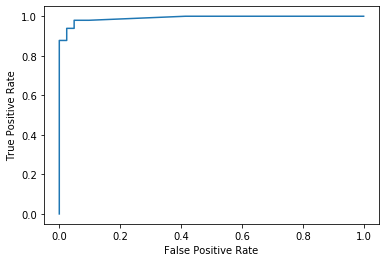

In [210]:
#1d. iii. TEST SET

prediction = lg.predict(X_test)
predict_prob = lg.predict_proba(X_test)
print(prediction)

conf_matrix = skm.confusion_matrix(y_test, prediction)
print("Confusion matrix: \n" + str(conf_matrix))
#ROC?

precision = skm.precision_score(y_test, prediction)
print("Precision: " + str(precision))

recall = skm.recall_score(y_test, prediction)
print("Recall: " + str(recall))
#print(precision)
#print(recall)
f1 = skm.f1_score(y_test, prediction)
print("F1 Score: " + str(f1))

#ROC
# Subset the probabilities of the positive class
pos_prob = predict_prob[:, 1]
fpr, tpr, _ = skm.roc_curve(y_test, pos_prob)

plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# ROC AUC
auc = skm.roc_auc_score(y_test, pos_prob)
print("Area Under Curve: " + str(auc))

# F_Beta score
beta = [0.1, 0.5, 0.9, 1, 5, 10]
for i in range(6):
    f_b = skm.fbeta_score(y_test, prediction, beta[i])
    print("Beta " + str(beta[i]) + ": " + str(f_b))

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0]
Confusion matrix: 
[[35  6]
 [ 1 48]]
Precision: 0.8888888888888888
Recall: 0.9795918367346939
F1 Score: 0.9320388349514563
Area Under Curve: 0.9166251866600298


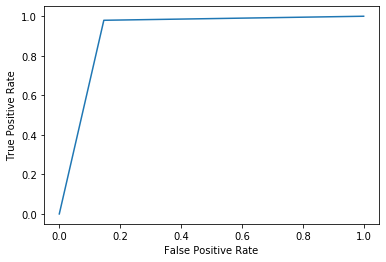

In [211]:
# 1f) Naive Bayes' with Gaussian (Test Set)
gnb = GaussianNB().fit(X_train, y_train)
prediction = gnb.predict(X_test)
predict_prob = gnb.predict_proba(X_test)
print(prediction)

conf_matrix = skm.confusion_matrix(y_test, prediction)
print("Confusion matrix: \n" + str(conf_matrix))
#ROC?

precision = skm.precision_score(y_test, prediction)
print("Precision: " + str(precision))

recall = skm.recall_score(y_test, prediction)
print("Recall: " + str(recall))
#print(precision)
#print(recall)
f1 = skm.f1_score(y_test, prediction)
print("F1 Score: " + str(f1))

#ROC
# Subset the probabilities of the positive class
pos_prob = predict_prob[:, 1]
fpr, tpr, _ = skm.roc_curve(y_test, pos_prob)

plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# ROC AUC
auc = skm.roc_auc_score(y_test, pos_prob)
print("Area Under Curve: " + str(auc))

Confusion matrix: 
[[162   0]
 [  1 195]]
Precision: 1.0
Recall: 0.9948979591836735
F1 Score: 0.9974424552429668
Area Under Curve: 0.9974489795918368


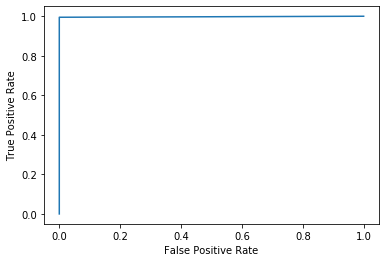

In [212]:
## TRAIN SET
prediction = gnb.predict(X_train)
predict_prob = gnb.predict_proba(X_train)

conf_matrix = skm.confusion_matrix(y_train, prediction)
print("Confusion matrix: \n" + str(conf_matrix))
#ROC?

precision = skm.precision_score(y_train, prediction)
print("Precision: " + str(precision))

recall = skm.recall_score(y_train, prediction)
print("Recall: " + str(recall))
#print(precision)
#print(recall)
f1 = skm.f1_score(y_train, prediction)
print("F1 Score: " + str(f1))

#ROC
# Subset the probabilities of the positive class
pos_prob = predict_prob[:, 1]
fpr, tpr, _ = skm.roc_curve(y_train, pos_prob)

plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# ROC AUC
auc = skm.roc_auc_score(y_train, pos_prob)
print("Area Under Curve: " + str(auc))


[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 1 0 0 0 0
 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
Confusion matrix: 
[[33  8]
 [ 0 49]]
Precision: 0.8596491228070176
Recall: 1.0
F1 Score: 0.9245283018867925
Area Under Curve: 0.9940268790443006


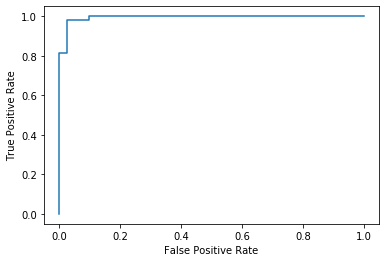

In [213]:
# 1g) Naive Bayes' with Multinomial (Test Set)
mnb = MultinomialNB().fit(X_train, y_train)
prediction = mnb.predict(X_test)
predict_prob = mnb.predict_proba(X_test)
print(prediction)

conf_matrix = skm.confusion_matrix(y_test, prediction)
print("Confusion matrix: \n" + str(conf_matrix))
#ROC?

precision = skm.precision_score(y_test, prediction)
print("Precision: " + str(precision))

recall = skm.recall_score(y_test, prediction)
print("Recall: " + str(recall))
#print(precision)
#print(recall)
f1 = skm.f1_score(y_test, prediction)
print("F1 Score: " + str(f1))

#ROC
# Subset the probabilities of the positive class
pos_prob = predict_prob[:, 1]
fpr, tpr, _ = skm.roc_curve(y_test, pos_prob)

plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# ROC AUC
auc = skm.roc_auc_score(y_test, pos_prob)
print("Area Under Curve: " + str(auc))

Confusion matrix: 
[[154   8]
 [  0 196]]
Precision: 0.9607843137254902
Recall: 1.0
F1 Score: 0.98
Area Under Curve: 0.9991496598639454


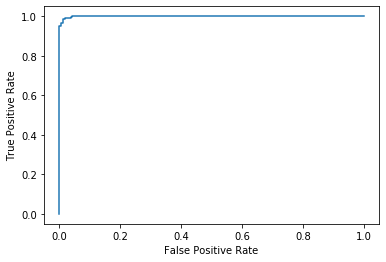

In [214]:
## TRAIN SET
prediction = mnb.predict(X_train)
predict_prob = mnb.predict_proba(X_train)

conf_matrix = skm.confusion_matrix(y_train, prediction)
print("Confusion matrix: \n" + str(conf_matrix))
#ROC?

precision = skm.precision_score(y_train, prediction)
print("Precision: " + str(precision))

recall = skm.recall_score(y_train, prediction)
print("Recall: " + str(recall))
#print(precision)
#print(recall)
f1 = skm.f1_score(y_train, prediction)
print("F1 Score: " + str(f1))

#ROC
# Subset the probabilities of the positive class
pos_prob = predict_prob[:, 1]
fpr, tpr, _ = skm.roc_curve(y_train, pos_prob)

plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# ROC AUC
auc = skm.roc_auc_score(y_train, pos_prob)
print("Area Under Curve: " + str(auc))

In [257]:
# 1h
class Stats:
    def __init__(self, path):
        self.df = pd.read_csv(path)
        
    def TFIDF(self):
        s = self.df.CLASS[df.CLASS == 1].index.tolist()
        h = self.df.CLASS[df.CLASS == 0].index.tolist()
        traini = s[:int(len(s)*0.8)] + h[:int(len(h)*0.8)]
        testi = s[int(len(s)*0.8):] + h[int(len(h)*0.8):]

        train_set = self.df.iloc[traini]
        test_set = self.df.iloc[testi]
        
        v = TfidfVectorizer()
        X = v.fit_transform(self.df.CONTENT)
        X_df = pd.DataFrame(X.toarray())

        self.X_train = X_df.iloc[traini]
        self.X_test = X_df.iloc[testi]
        self.y_train = train_set.CLASS
        self.y_test = test_set.CLASS
    
    def LogitL2(self):
        ## 5-fold cross validation
        l = 10**np.linspace(-5, 5, 11)
        kf = KFold(n_splits=5, random_state=0)
        mean_agg = []
        for i in range(len(l)-9):
            lr = LogisticRegression(penalty = 'l2', C = 1/l[i], solver='lbfgs')
            error_ptg = []
            for train_index, test_index in kf.split(self.X_train):
                #print("TRAIN:", train_index, "TEST:", test_index)
                X_tr, X_va = self.X_train.iloc[train_index], self.X_train.iloc[test_index]
                y_tr, y_va = self.y_train.iloc[train_index], self.y_train.iloc[test_index]
                #print(X_tr)
                #print(y_tr)
                lr.fit(X_tr, y_tr)
                prediction = lr.predict(X_va)

                # Calculate percentage difference
                diff = pd.DataFrame({'different': prediction != y_va})
                percentage = diff['different'].value_counts(normalize=True) * 100
                error_ptg.append(percentage[True])
            mean_agg.append(np.mean(error_ptg))
        penalty = l[np.argmin(mean_agg)]
        
        ## FIT to L2 ##
        lg = LogisticRegression(penalty = 'l2', C = 1/penalty, solver='lbfgs')
        lg.fit(self.X_train, self.y_train)
        prediction = lg.predict(self.X_test)
        predict_prob = lg.predict_proba(self.X_test)
        
        ## STATS CALCULATION ##
        accuracy = skm.accuracy_score(self.y_test, prediction)
        precision = skm.precision_score(self.y_test, prediction)
        recall = skm.recall_score(self.y_test, prediction)
        f1 = skm.f1_score(self.y_test, prediction)
        pos_prob = predict_prob[:, 1]
        auc_l2 = skm.roc_auc_score(self.y_test, pos_prob)
        self.l2 = ["Logit (L2)", accuracy, precision, recall, f1, auc_l2]
            
    def LogitL1(self):
        #1e) i. 5-fold cross validation with L1 penalization
        l = 10**np.linspace(-5, 5, 11)

        kf = KFold(n_splits=5, random_state=0)
        mean_agg = []
        for i in range(len(l)-4):
            lr = LogisticRegression(penalty = 'l1', C = 1/l[i], solver='liblinear')
            error_ptg = []
            for train_index, test_index in kf.split(self.X_train):
                #print("TRAIN:", train_index, "TEST:", test_index)
                X_tr, X_va = self.X_train.iloc[train_index], self.X_train.iloc[test_index]
                y_tr, y_va = self.y_train.iloc[train_index], self.y_train.iloc[test_index]
                lr.fit(X_tr, y_tr)
                prediction = lr.predict(X_va)

                # Calculate percentage difference
                diff = pd.DataFrame({'different': prediction != y_va})
                percentage = 100*diff['different'].value_counts(normalize=True)
                error_ptg.append(percentage[True])
            mean_agg.append(np.mean(error_ptg))
        penalty = l[np.argmin(mean_agg)]
        
        ## FIT to L1 ##
        lg = LogisticRegression(penalty = 'l1', C = 1/penalty, solver='liblinear')
        lg.fit(self.X_train, self.y_train)
        prediction = lg.predict(self.X_test)
        predict_prob = lg.predict_proba(self.X_test)

        accuracy = skm.accuracy_score(self.y_test, prediction)
        precision = skm.precision_score(self.y_test, prediction)
        recall = skm.recall_score(self.y_test, prediction)
        f1 = skm.f1_score(self.y_test, prediction)
        pos_prob = predict_prob[:, 1]
        auc = skm.roc_auc_score(self.y_test, pos_prob)
        self.l1 = ["Logit (L1)", accuracy, precision, recall, f1, auc]

        
    def GaussianNB(self):
        gnb = GaussianNB().fit(self.X_train, self.y_train)
        prediction = gnb.predict(self.X_test)
        predict_prob = gnb.predict_proba(self.X_test)

        accuracy = skm.accuracy_score(self.y_test, prediction)
        precision = skm.precision_score(self.y_test, prediction)
        recall = skm.recall_score(self.y_test, prediction)
        f1 = skm.f1_score(self.y_test, prediction)
        pos_prob = predict_prob[:, 1]
        auc = skm.roc_auc_score(self.y_test, pos_prob)
        self.gnb = ["NB-Gaussian", accuracy, precision, recall, f1, auc]
        
    def MultiNB(self):
        mnb = MultinomialNB().fit(self.X_train, self.y_train)
        prediction = mnb.predict(self.X_test)
        predict_prob = mnb.predict_proba(self.X_test)

        self.mnbaccuracy = skm.accuracy_score(self.y_test, prediction)
        self.mnbprecision = skm.precision_score(self.y_test, prediction)
        self.mnbrecall = skm.recall_score(self.y_test, prediction)
        self.mnbf1 = skm.f1_score(self.y_test, prediction)
        pos_prob = predict_prob[:, 1]
        self.mnbauc = skm.roc_auc_score(self.y_test, pos_prob)
        self.mnb = ["NB-Multinomial", self.mnbaccuracy, self.mnbprecision, self.mnbrecall, self.mnbf1, self.mnbauc]
    
    def Table(self):
        self.TFIDF()
        self.LogitL2()
        self.LogitL1()
        self.GaussianNB()    
        self.MultiNB()
        c = ["Instance", "Accuracy", "Precision", "Recall", "F1", "AUC"]
        d = [self.l2, self.l1, self.gnb, self.mnb]
        self.stats = pd.DataFrame(d, columns=c)
        print(self.stats)

In [258]:
## EMINEM
e = Stats("../Data/Youtube04-Eminem.csv")
e.Table()

         Instance  Accuracy  Precision    Recall        F1       AUC
0      Logit (L2)  0.955556   0.978723  0.938776  0.958333  0.994027
1      Logit (L1)  0.922222   0.977273  0.877551  0.924731  0.994525
2     NB-Gaussian  0.922222   0.888889  0.979592  0.932039  0.916625
3  NB-Multinomial  0.911111   0.859649  1.000000  0.924528  0.994027


'\npsy = Table("../Data/Youtube01-Psy.csv")\npsy.Execute()\nprint(psy.stats)\n\nkp = Table("../Data/Youtube02-KatyPerry.csv")\nkp.Execute()\nprint(kp.stats)'

In [259]:
## SHAKIRA
sh = Stats("../Data/Youtube05-Shakira.csv")
sh.Table()

         Instance  Accuracy  Precision    Recall        F1       AUC
0      Logit (L2)  0.973333   0.983607  0.983607  0.983607  0.996487
1      Logit (L1)  0.973333   1.000000  0.967213  0.983333  0.997658
2     NB-Gaussian  0.986667   0.983871  1.000000  0.991870  0.964286
3  NB-Multinomial  0.893333   1.000000  0.868852  0.929825  0.995316


/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [260]:
## PSY
psy = Stats("../Data/Youtube01-Psy.csv")
psy.Table()

         Instance  Accuracy  Precision    Recall        F1       AUC
0      Logit (L2)  0.942857   1.000000  0.891892  0.942857  0.994267
1      Logit (L1)  0.928571   0.944444  0.918919  0.931507  0.990991
2     NB-Gaussian  0.842857   0.906250  0.783784  0.840580  0.846437
3  NB-Multinomial  0.942857   0.945946  0.945946  0.945946  0.992629


/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [261]:
## KATY PERRY
kp = Stats("../Data/Youtube02-KatyPerry.csv")
kp.Table()

         Instance  Accuracy  Precision   Recall        F1       AUC
0      Logit (L2)  0.914286   0.964286  0.84375  0.900000  0.967105
1      Logit (L1)  0.957143   0.967742  0.93750  0.952381  0.969572
2     NB-Gaussian  0.828571   0.763158  0.90625  0.828571  0.834704
3  NB-Multinomial  0.914286   0.933333  0.87500  0.903226  0.963816


In [263]:
## LMFAO
lmfao = Stats("../Data/Youtube03-LMFAO.csv")
lmfao.Table()

         Instance  Accuracy  Precision    Recall        F1       AUC
0      Logit (L2)  0.875000   1.000000  0.845070  0.916031  0.986744
1      Logit (L1)  0.897727   1.000000  0.873239  0.932331  0.970174
2     NB-Gaussian  0.897727   0.984375  0.887324  0.933333  0.907622
3  NB-Multinomial  0.886364   1.000000  0.859155  0.924242  0.982601
